Found 86989 images belonging to 43 classes.
Found 4410 images belonging to 43 classes.
Found 12630 images belonging to 43 classes.


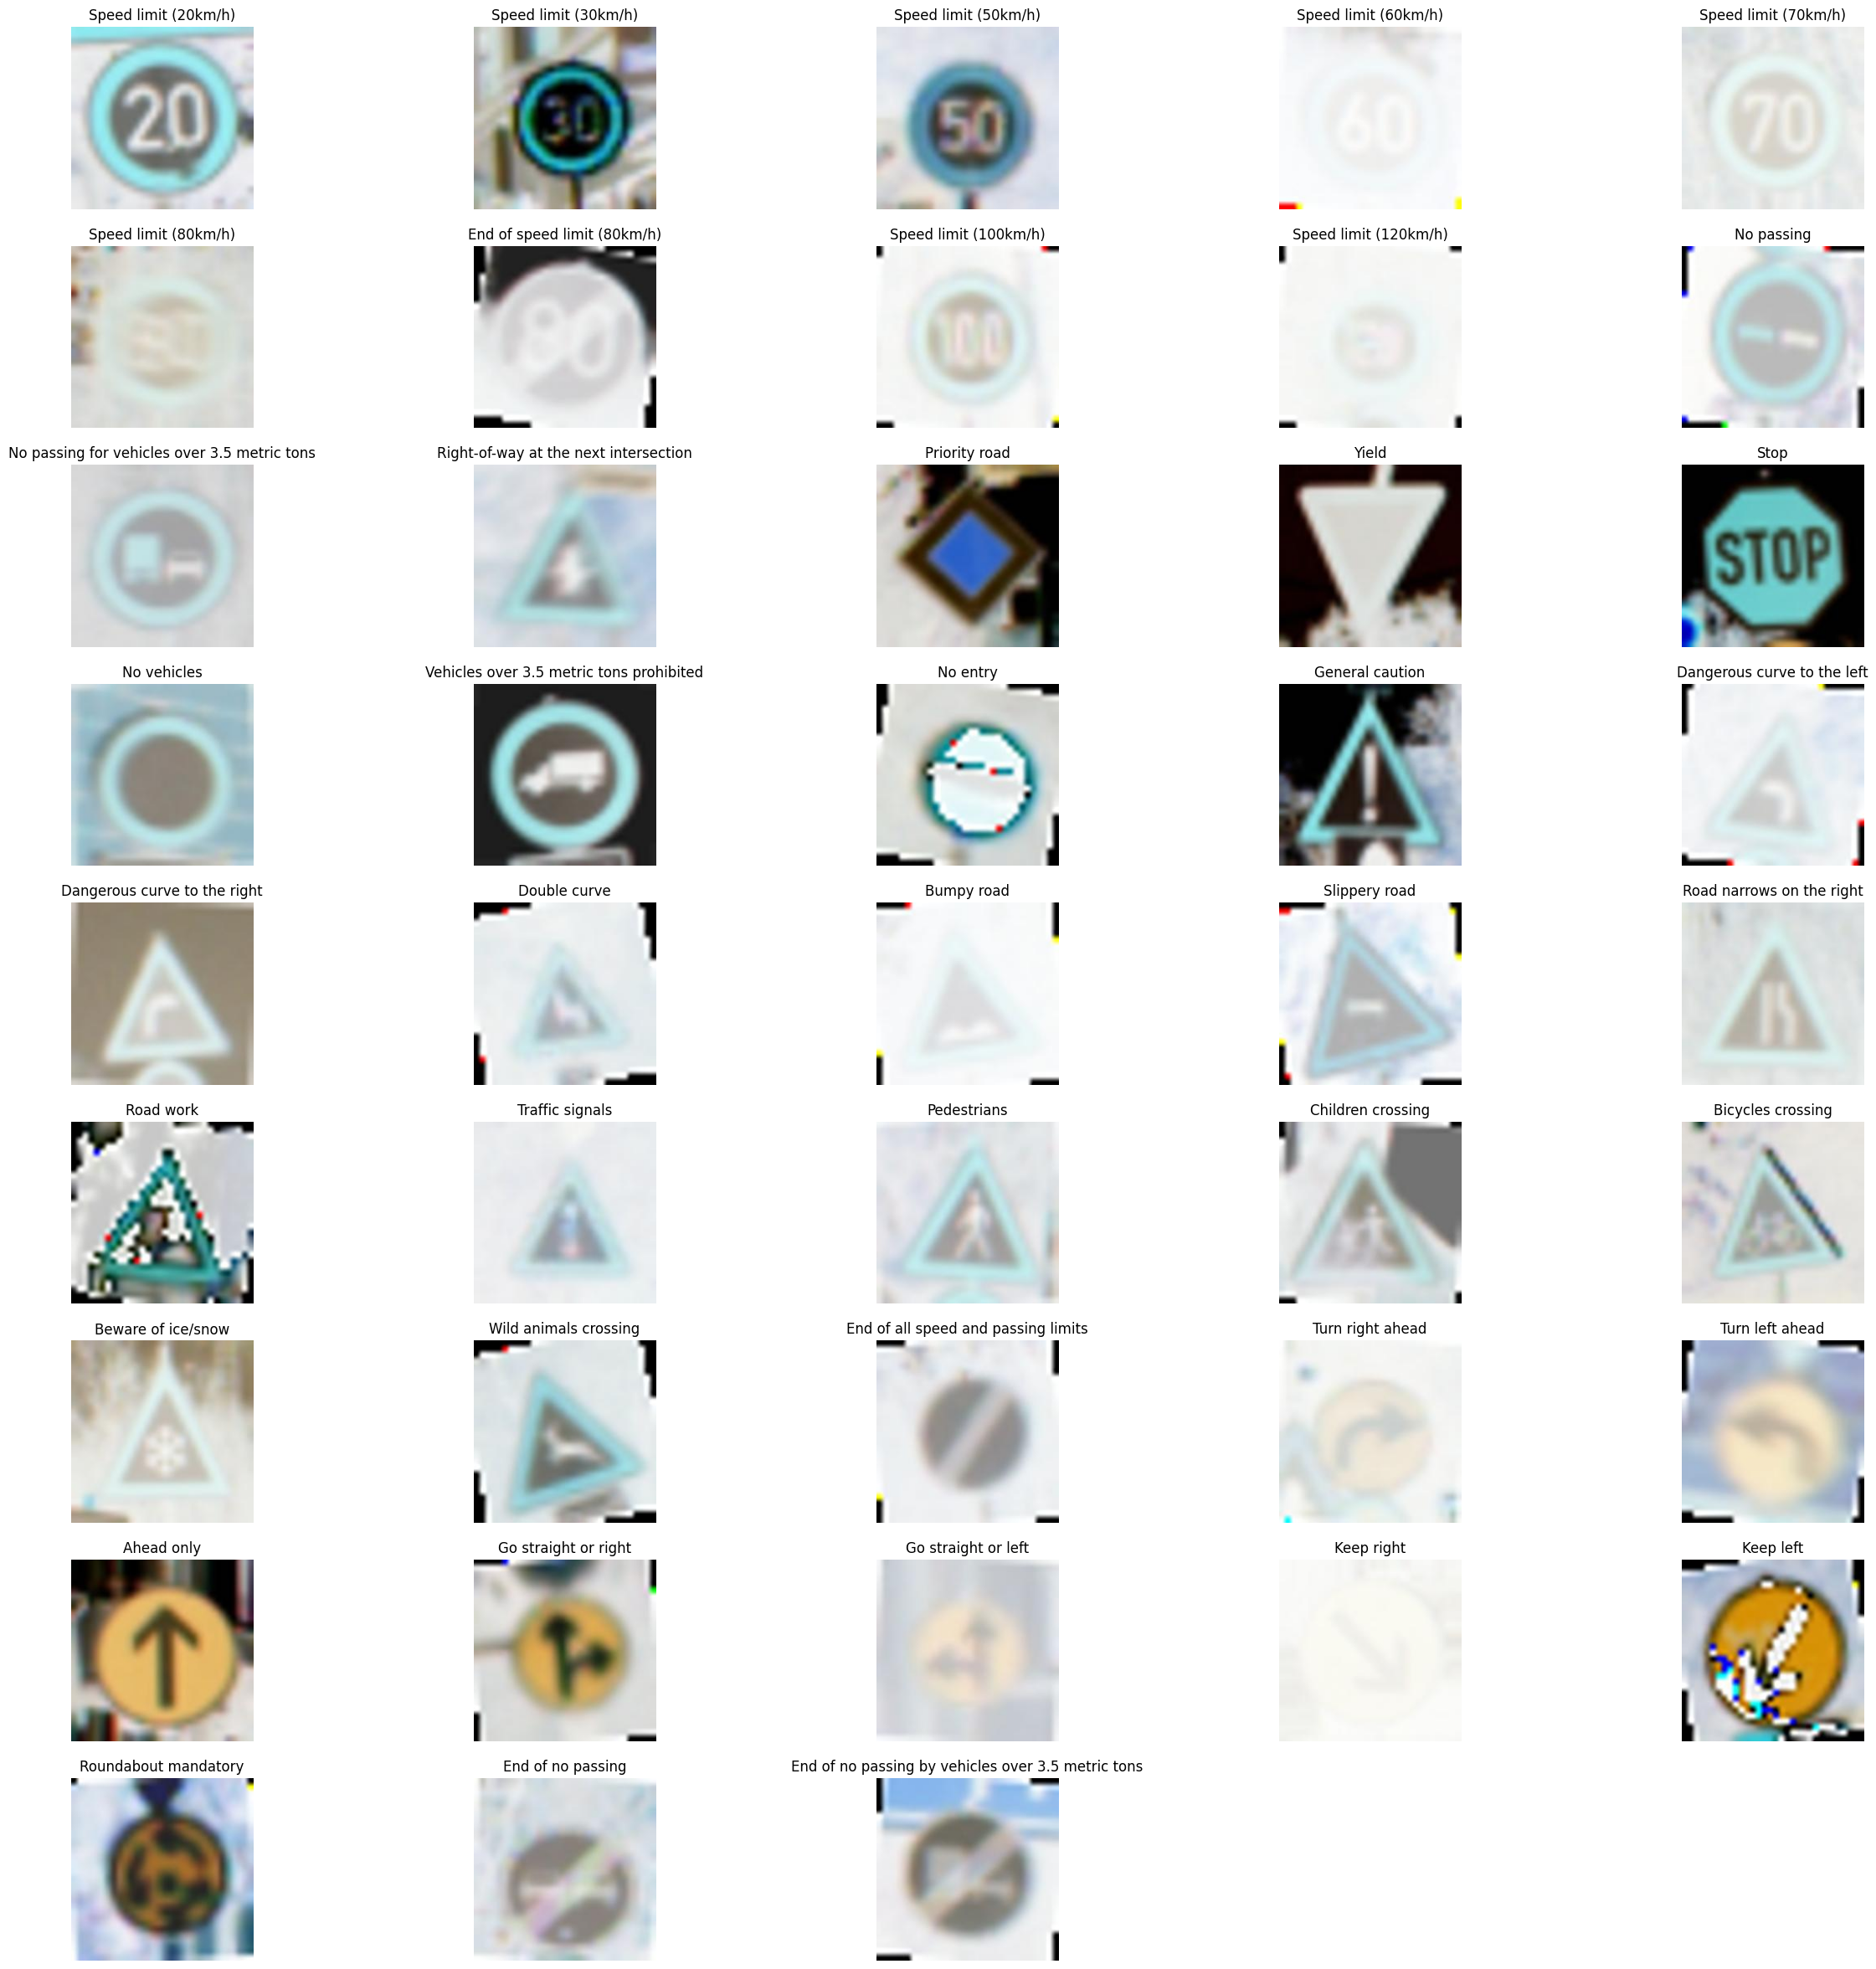

In [1]:
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler

# Constants
BATCH_SIZE = 64
IMAGE_SIZE = (224, 224)
NUM_CLASSES = 43  # Number of classes for traffic signs
LEARNING_RATE = 0.0005
EPOCHS_PHASE1 = 10
EPOCHS_PHASE2 = 10

# Define the paths to the train, valid, and test directories
train_dir = "F:\DATASET\TRAFFIC SIGNS PICKLE DATA 0 224x224/train"
valid_dir = "F:\DATASET\TRAFFIC SIGNS PICKLE DATA 0 224x224/valid"
test_dir = "F:\DATASET\TRAFFIC SIGNS PICKLE DATA 0 224x224/test"

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
# Load sign names from the CSV file
label_names_path = "G:\Datasets\Traffic Signs\label_names.csv"
label_names_df = pd.read_csv(label_names_path)

# Create a dictionary mapping class IDs to sign names
class_names = dict(zip(label_names_df["ClassId"], label_names_df["SignName"]))

# Load and augment the training data with the correct class names list
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',  # Use "sparse" class_mode
    classes=[str(i) for i in range(NUM_CLASSES)],  # Set the classes parameter
    shuffle=True
)

# Load the validation data with the correct class names list
valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',  # Use "sparse" class_mode
    classes=[str(i) for i in range(NUM_CLASSES)],  # Set the classes parameter
    shuffle=False
)

# Load the test data with the correct class names list
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',  # Use "sparse" class_mode
    classes=[str(i) for i in range(NUM_CLASSES)],  # Set the classes parameter
    shuffle=False
)

# Display one image per class from the training set
plt.figure(figsize=(30, 30))
for class_id in range(NUM_CLASSES):
    # Find the first image belonging to the current class
    for i in range(len(train_generator.filenames)):
        if train_generator.labels[i] == class_id:
            img_path = os.path.join(train_dir, train_generator.filenames[i])
            break

    class_name = class_names[class_id]
    plt.subplot(9, 5, class_id + 1)
    plt.imshow(plt.imread(img_path))
    plt.title(class_name)
    plt.axis('off')

In [2]:
# Function to count images per class
def count_images_per_class(generator):
    class_counts = {class_name: 0 for class_name in class_names.values()}
    for label in generator.labels:
        class_name = class_names[label]
        class_counts[class_name] += 1
    return class_counts

# Count images per class for train, validation, and test sets
train_class_counts = count_images_per_class(train_generator)
valid_class_counts = count_images_per_class(valid_generator)
test_class_counts = count_images_per_class(test_generator)

# Create DataFrames for the counts
train_class_counts_df = pd.DataFrame(train_class_counts.items(), columns=['Class Name', 'Train Count'])
valid_class_counts_df = pd.DataFrame(valid_class_counts.items(), columns=['Class Name', 'Validation Count'])
test_class_counts_df = pd.DataFrame(test_class_counts.items(), columns=['Class Name', 'Test Count'])

# Display tables
print("Number of images per class in Train Set:")
print(train_class_counts_df)

print("\nNumber of images per class in Validation Set:")
print(valid_class_counts_df)

print("\nNumber of images per class in Test Set:")
print(test_class_counts_df)

Number of images per class in Train Set:
                                           Class Name  Train Count
0                                Speed limit (20km/h)         2023
1                                Speed limit (30km/h)         2023
2                                Speed limit (50km/h)         2023
3                                Speed limit (60km/h)         2023
4                                Speed limit (70km/h)         2023
5                                Speed limit (80km/h)         2023
6                         End of speed limit (80km/h)         2023
7                               Speed limit (100km/h)         2023
8                               Speed limit (120km/h)         2023
9                                          No passing         2023
10       No passing for vehicles over 3.5 metric tons         2023
11              Right-of-way at the next intersection         2023
12                                      Priority road         2023
13                   

In [3]:
base_model = tf.keras.applications.MobileNetV3Large(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)  # Updated input shape
)

# Freeze base layers for the first 10 epochs
# for layer in base_model.layers:
#     layer.trainable = False

# Add custom top layers for classification
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = layers.Dropout(0.3)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with Adam optimizer and set learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization)                                                                                    

In [4]:
# Train the model for the first 10 epochs with frozen base layers
model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator
)

Epoch 1/10
1360/1360 [==============================] - 1452s 1s/step - loss: 2.9710 - accuracy: 0.2150 - val_loss: 6.9363 - val_accuracy: 0.0757
Epoch 2/10
1360/1360 [==============================] - 1502s 1s/step - loss: 2.4492 - accuracy: 0.3427 - val_loss: 9.4664 - val_accuracy: 0.0590
Epoch 3/10
1360/1360 [==============================] - 1346s 989ms/step - loss: 2.2499 - accuracy: 0.3938 - val_loss: 14.4089 - val_accuracy: 0.0295
Epoch 4/10
1360/1360 [==============================] - 1343s 987ms/step - loss: 2.1336 - accuracy: 0.4262 - val_loss: 12.6100 - val_accuracy: 0.1059
Epoch 5/10
1360/1360 [==============================] - 1376s 1s/step - loss: 2.0526 - accuracy: 0.4460 - val_loss: 11.8046 - val_accuracy: 0.1288
Epoch 6/10
1360/1360 [==============================] - 1338s 984ms/step - loss: 1.9938 - accuracy: 0.4636 - val_loss: 21.8277 - val_accuracy: 0.0184
Epoch 7/10
1360/1360 [==============================] - 1302s 958ms/step - loss: 1.9367 - accuracy: 0.4754 - va

In [7]:
# Unfreeze all layers except BatchNormalization for the next 10 epochs (/freeze batch norm)
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False
    else:
        layer.trainable = True

# Compile the model again after unfreezing(/freezing)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
# Train the fine-tuned model for the next 10 epochs
history_phase2 = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator
)

Epoch 1/10
1360/1360 [==============================] - 4730s 3s/step - loss: 5.2277 - accuracy: 0.2335 - val_loss: 2.3909 - val_accuracy: 0.4020
Epoch 2/10
1360/1360 [==============================] - 5016s 4s/step - loss: 2.4450 - accuracy: 0.4144 - val_loss: 2.3519 - val_accuracy: 0.4469
Epoch 3/10
1360/1360 [==============================] - 5283s 4s/step - loss: 1.8499 - accuracy: 0.5257 - val_loss: 1.9091 - val_accuracy: 0.5379
Epoch 4/10
1360/1360 [==============================] - 5291s 4s/step - loss: 1.5155 - accuracy: 0.6070 - val_loss: 1.5541 - val_accuracy: 0.5887
Epoch 5/10
1360/1360 [==============================] - 5292s 4s/step - loss: 1.2475 - accuracy: 0.6761 - val_loss: 0.8356 - val_accuracy: 0.7558
Epoch 6/10
1360/1360 [==============================] - 5350s 4s/step - loss: 0.9860 - accuracy: 0.7405 - val_loss: 1.0509 - val_accuracy: 0.7179
Epoch 7/10
1360/1360 [==============================] - 5627s 4s/step - loss: 0.8419 - accuracy: 0.7846 - val_loss: 0.6328 -

In [10]:
# Train the fine-tuned model for the next 10 epochs
history_phase3 = model.fit(
    train_generator,
    epochs=8,
    validation_data=valid_generator
)

Epoch 1/8
1360/1360 [==============================] - 4904s 4s/step - loss: 0.3947 - accuracy: 0.9022 - val_loss: 0.2675 - val_accuracy: 0.9320
Epoch 2/8
1360/1360 [==============================] - 4690s 3s/step - loss: 0.3543 - accuracy: 0.9137 - val_loss: 0.3164 - val_accuracy: 0.9202
Epoch 3/8
1360/1360 [==============================] - 5043s 4s/step - loss: 0.2855 - accuracy: 0.9324 - val_loss: 0.4188 - val_accuracy: 0.9104
Epoch 4/8
1360/1360 [==============================] - 5100s 4s/step - loss: 0.2588 - accuracy: 0.9391 - val_loss: 0.4482 - val_accuracy: 0.9054
Epoch 5/8
1360/1360 [==============================] - 4846s 4s/step - loss: 0.2184 - accuracy: 0.9495 - val_loss: 0.2700 - val_accuracy: 0.9454
Epoch 6/8
1360/1360 [==============================] - 4964s 4s/step - loss: 0.2112 - accuracy: 0.9531 - val_loss: 0.2674 - val_accuracy: 0.9454
Epoch 7/8
1360/1360 [==============================] - 4837s 4s/step - loss: 0.1827 - accuracy: 0.9602 - val_loss: 0.2729 - val_ac

In [12]:
# Train the fine-tuned model for the next 10 epochs
history_phase4 = model.fit(
    train_generator,
    epochs=8,
    validation_data=valid_generator
)

Epoch 1/8
1360/1360 [==============================] - 4561s 3s/step - loss: 0.1433 - accuracy: 0.9696 - val_loss: 0.3889 - val_accuracy: 0.9560
Epoch 2/8
1360/1360 [==============================] - 4391s 3s/step - loss: 0.1189 - accuracy: 0.9748 - val_loss: 0.2336 - val_accuracy: 0.9571
Epoch 3/8
1360/1360 [==============================] - 4162s 3s/step - loss: 0.1191 - accuracy: 0.9747 - val_loss: 0.3405 - val_accuracy: 0.9544
Epoch 4/8
1360/1360 [==============================] - 4152s 3s/step - loss: 0.0950 - accuracy: 0.9799 - val_loss: 0.2104 - val_accuracy: 0.9669
Epoch 5/8
1360/1360 [==============================] - 4160s 3s/step - loss: 0.0945 - accuracy: 0.9806 - val_loss: 0.2134 - val_accuracy: 0.9726
Epoch 6/8
1360/1360 [==============================] - 4157s 3s/step - loss: 0.0760 - accuracy: 0.9842 - val_loss: 0.3479 - val_accuracy: 0.9587
Epoch 7/8
1360/1360 [==============================] - 4150s 3s/step - loss: 0.0745 - accuracy: 0.9847 - val_loss: 0.3770 - val_ac

In [13]:
# Train the fine-tuned model for the next 10 epochs
history_phase5 = model.fit(
    train_generator,
    epochs=5,
    validation_data=valid_generator
)

Epoch 1/5
1360/1360 [==============================] - 4607s 3s/step - loss: 0.0602 - accuracy: 0.9887 - val_loss: 0.4612 - val_accuracy: 0.9617
Epoch 2/5
1360/1360 [==============================] - 4389s 3s/step - loss: 0.0609 - accuracy: 0.9882 - val_loss: 0.2799 - val_accuracy: 0.9644
Epoch 3/5
1360/1360 [==============================] - 4487s 3s/step - loss: 0.0562 - accuracy: 0.9896 - val_loss: 0.1421 - val_accuracy: 0.9816
Epoch 4/5
1360/1360 [==============================] - 4634s 3s/step - loss: 0.0562 - accuracy: 0.9896 - val_loss: 0.3087 - val_accuracy: 0.9687
Epoch 5/5
1360/1360 [==============================] - 4303s 3s/step - loss: 0.0494 - accuracy: 0.9907 - val_loss: 0.3965 - val_accuracy: 0.9753


In [15]:
history_phase6 = model.fit(
    train_generator,
    epochs=5,
    validation_data=valid_generator
)

Epoch 1/5
1360/1360 [==============================] - 5047s 4s/step - loss: 0.0466 - accuracy: 0.9913 - val_loss: 0.2814 - val_accuracy: 0.9798
Epoch 2/5
1360/1360 [==============================] - 4908s 4s/step - loss: 0.0414 - accuracy: 0.9924 - val_loss: 0.3410 - val_accuracy: 0.9664
Epoch 3/5
1360/1360 [==============================] - 4905s 4s/step - loss: 0.0373 - accuracy: 0.9928 - val_loss: 0.4085 - val_accuracy: 0.9717
Epoch 4/5
1360/1360 [==============================] - 4951s 4s/step - loss: 0.0511 - accuracy: 0.9914 - val_loss: 0.4176 - val_accuracy: 0.9732
Epoch 5/5
1360/1360 [==============================] - 4654s 3s/step - loss: 0.0316 - accuracy: 0.9941 - val_loss: 0.1563 - val_accuracy: 0.9823


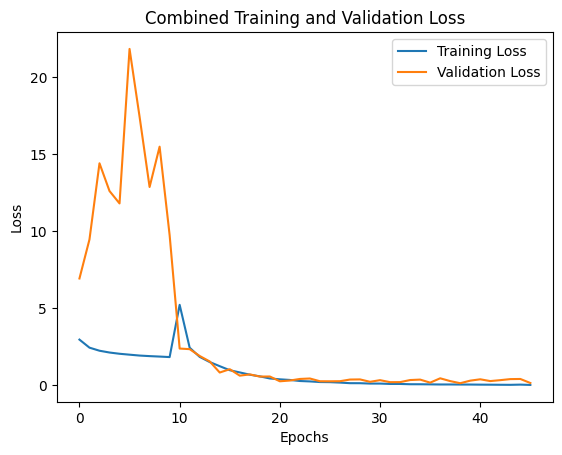

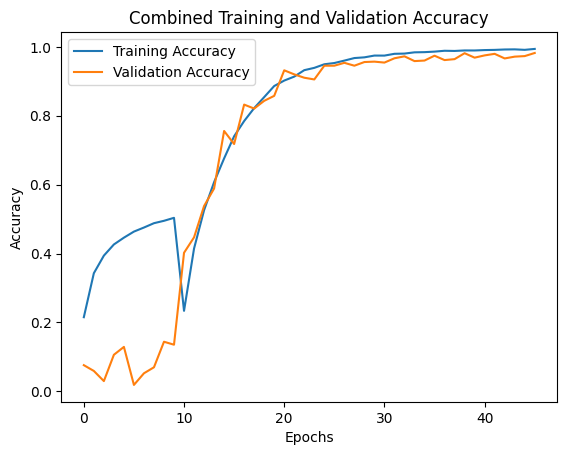

In [16]:
combined_history_loss = {'loss': [], 'val_loss': []}
combined_history_accuracy = {'accuracy': [], 'val_accuracy': []}

# Combine histories from all phases
for history in [history_phase1, history_phase2, history_phase3, history_phase4, history_phase5, history_phase6]:
    combined_history_loss['loss'].extend(history.history['loss'])
    combined_history_loss['val_loss'].extend(history.history['val_loss'])
    combined_history_accuracy['accuracy'].extend(history.history['accuracy'])
    combined_history_accuracy['val_accuracy'].extend(history.history['val_accuracy'])

# Plot combined training and validation loss
plt.plot(combined_history_loss['loss'], label='Training Loss')
plt.plot(combined_history_loss['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Combined Training and Validation Loss')
plt.legend()
plt.show()

# Plot combined training and validation accuracy
plt.plot(combined_history_accuracy['accuracy'], label='Training Accuracy')
plt.plot(combined_history_accuracy['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Combined Training and Validation Accuracy')
plt.legend()
plt.show()

In [17]:
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

# Get the predicted class probabilities for the test set
predicted_probabilities = model.predict(test_generator)

# Convert the predicted probabilities into class labels
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Get the true labels from the test set generator
true_labels = test_generator.labels

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:")
print(conf_matrix)

# Compute additional performance metrics
report = classification_report(true_labels, predicted_labels)
print("Classification Report:")
print(report)

198/198 [==============================] - 226s 1s/step - loss: 0.4484 - accuracy: 0.9629
Test Loss: 0.4483672082424164
Test Accuracy: 0.9628661870956421
198/198 [==============================] - 201s 1s/step
Confusion Matrix:
[[ 60   0   0 ...   0   0   0]
 [  0 712   0 ...   1   0   0]
 [  0   3 747 ...   0   0   0]
 ...
 [  0   1   0 ...  88   0   0]
 [  0   0   0 ...   0  51   0]
 [  0   0   0 ...   0   0  90]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        60
           1       0.98      0.99      0.98       720
           2       0.91      1.00      0.95       750
           3       1.00      0.78      0.88       450
           4       0.99      0.98      0.98       660
           5       0.91      0.97      0.94       630
           6       1.00      0.87      0.93       150
           7       0.99      0.98      0.98       450
           8       0.99      0.98      0.98       450
           9    

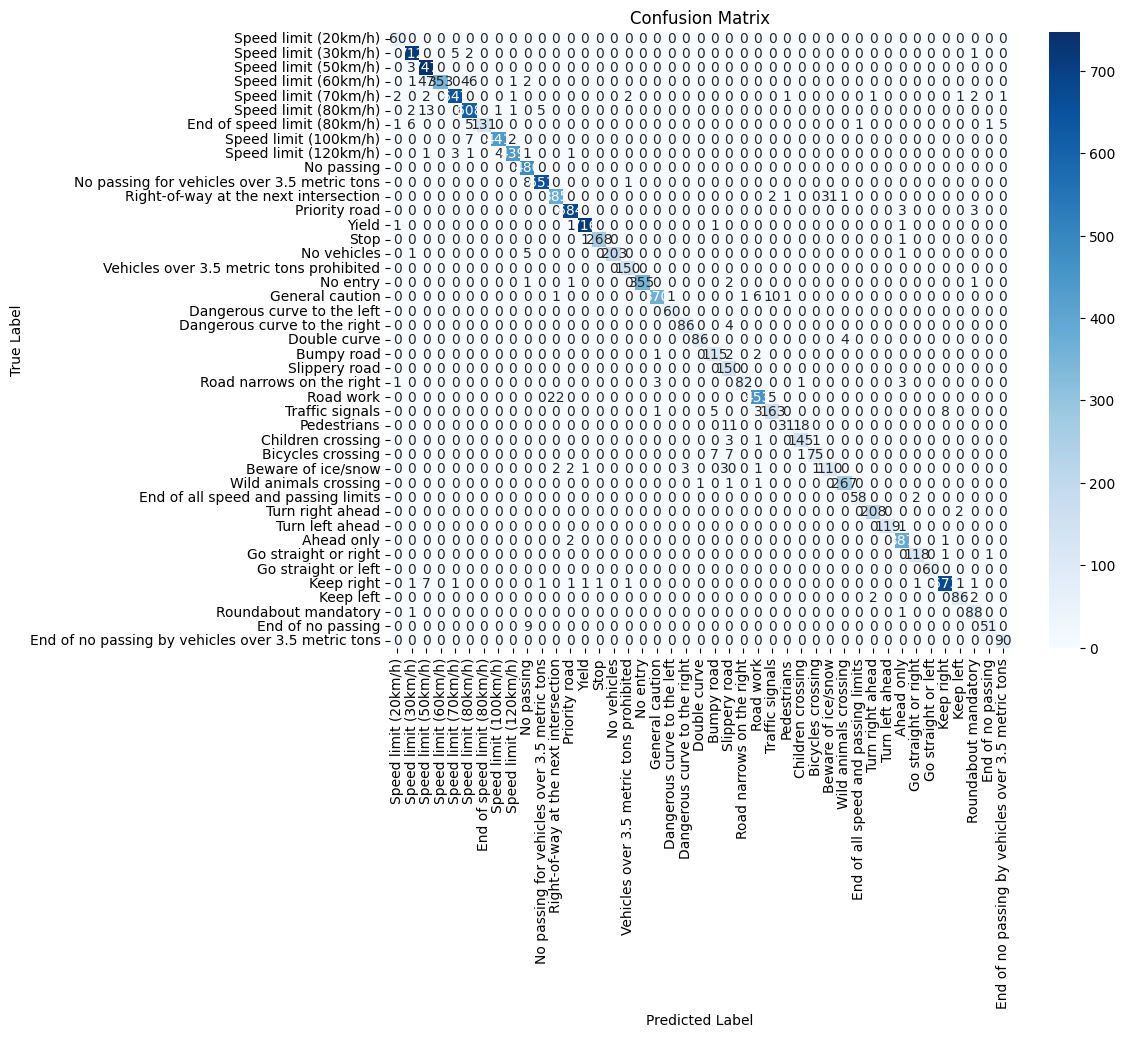

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=class_names.values(), yticklabels=class_names.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
## FOR DEMOSNTRATION
## THIS CELL LOADS AND USES THE ORIGINAL MOBILENET V3 LARGE MODEL, NOT THE ONE IN THIS NOTEBOOK

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64

test_dir = "F:\DATASET\TRAFFIC SIGNS PICKLE DATA 0 224x224/test"
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

In [2]:
# Load saved model
model = tf.keras.models.load_model('mobilenetv3_Large_traffic_signs.h5')

In [ ]:
loss, accuracy = model.evaluate(test_generator)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)